## There are two crucial stages for this bit. 

#### Firstly we need to be able to get the letters from the identity into their own boxes. Here you see an example, but its not so robust right now. 
#### Then we take 2 models trained, one trained on the relevant letters and one trained on the numbers (there are good publically available datasets) and predict. 

In [8]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
from image import *
import csv  
from io import BytesIO
from IPython import display

import torch
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy
from ML_helper import *

from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import h5py

np.random.seed(42)
tf.random.set_seed(42)

In [9]:
model = tf.keras.models.load_model('stringlookups.h5');

char_to_num = model.layers[0]
num_to_char = model.layers[1]

In [10]:
h5f = h5py.File(('dataset.h5'), 'r')

num_samples, image_height, image_width = h5f['images'].shape
max_len = h5f['labels'].shape[1]


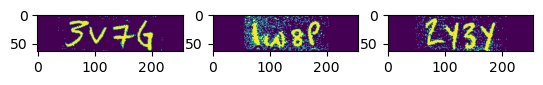

In [11]:
fig,ax = plt.subplots(1,3)

for i in range(3):
    ax[i].imshow(h5f['images'][i])


In [12]:
# h5f.close()

In [119]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model(lr):
    # Inputs to the model
    input_img = keras.Input(shape=(image_height, image_width, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv4",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv5",
    )(x)
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv6",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool3")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = (x.shape[1], x.shape[2] * x.shape[3])
    print(x.shape[1], x.shape[2] , 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1.5")(x)

    x = tf.transpose(x, perm=[0, 2, 1])
    x = keras.layers.Dense(8, activation="relu", name="dense1.7")(x)
    x = tf.transpose(x, perm=[0, 2, 1])


    # x = keras.layers.Dropout(0.2)(x)

    # # RNNs.
    # x = keras.layers.Bidirectional(
    #     keras.layers.LSTM(128, return_sequences=True)#, dropout=0.25)
    # )(x)
    # x = keras.layers.Bidirectional(
    #     keras.layers.LSTM(64, return_sequences=True)#, dropout=0.25)
    # )(x)





    allchars = char_to_num.get_vocabulary()[1:] # first element is 'unknown character'

    num_letters = len([c for c in allchars if c.isalpha()]) + 1 #1 is for blank
    num_numbers = len([c for c in allchars if c.isnumeric()]) + 1 #1 is for blank
   
    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    
    letters = keras.layers.Dense(64, activation="relu", name="denselets1")(x)
    
    letters = keras.layers.Dense(
        num_letters, activation="softmax", name="denselets2"
    )(letters)


    numbers = keras.layers.Dense(64, activation="relu", name="densenums1")(x)

    numbers = keras.layers.Dense(
        num_numbers, activation="softmax", name="densenums2"
    )(numbers)


    

    '''
    Now lets enforce some prior knowledge. We know numbers and letters alternate, and there are 8 characters. Therefore 4 of each. We also know that the first 4 characters cant be space.

    currently out letters layer outputs something of shape (number_of_letters + 1) where the 1 is the probability of space
    currently out numbers layer outputs something of shape (number_of_numbers + 1) where the 1 is the probability of space

    In the num_to_char dictionary, the first character is a 'UNKNOWN token, which we dont want to predict, so always have 0 there. Then, we have the numerical characters. then the alphabetical. then finally the space.
    Therefore for the numbers we should have the form [0, number1,number2..., 0,0,0,0..., space] and for letters: [0,0,0,..., letter1,letter2,...,space]

    However, the first 2 predictions for numbers and letters should have a 0 instead of space (Ie there is 0 probability they are a space). Here we need a zero at the start and end of each, (one for unknown token, one for space).
    Remember num_letters already contains one extra.
    '''

    letters = letters[:,:4] #we can have max 4 letters or numbers in string (assuming maximum 8)
    numbers = numbers[:,:4]

    letters_first_2 = tf.concat([tf.zeros([tf.shape(letters)[0], 2, num_numbers]), letters[:,:2,:-1], tf.zeros([tf.shape(letters)[0], 2, 1])], axis=2) #here we enforce it cant predict space
    numbers_first_2 = tf.concat([tf.zeros([tf.shape(numbers)[0], 2, 1]), numbers[:,:2,:-1], tf.zeros([tf.shape(numbers)[0], 2, num_letters])], axis=2) #here we enforce it cant predict space

    letters_last_2 = tf.concat([tf.zeros([tf.shape(letters)[0], 2, num_numbers]), letters[:,2:]], axis=2) 
    numbers_last_2 = tf.concat([tf.zeros([tf.shape(numbers)[0], 2, 1]), numbers[:,2:,:-1], tf.zeros([tf.shape(numbers)[0], 2, num_letters-1]), numbers[:,2:,-1:]], axis=2) 

    letters = tf.concat([letters_first_2, letters_last_2], axis=1)
    numbers = tf.concat([numbers_first_2, numbers_last_2], axis=1)

    x = keras.layers.Concatenate(axis=1, name='concatter')([numbers[:,:1], letters[:,:1], numbers[:,1:2], letters[:,1:2], numbers[:,2:3], letters[:,2:3], numbers[:,3:4], letters[:,3:4]] )

    
    # x = keras.layers.Dense(len(char_to_num.get_vocabulary())  , activation="softmax", name="dense2")(x)


    # x = keras.layers.Concatenate(axis=2, name='concatter')([tf.zeros([tf.shape(x)[0], tf.shape(x)[1], 1]), x[:,:,1:]]) 

    # # Add CTC layer for calculating CTC loss at each step.
    # output = CTCLayer(name="ctc_loss")(labels, x)

    # # # Define the model.
    # model = keras.models.Model(
    #     inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")
    # )

    model = keras.models.Model(inputs=input_img, outputs=x, name="handwriting_recognizer")

    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    # Optimizer.
    opt = keras.optimizers.Adam(lr = lr)
    # Compile the model and return.
    model.compile(optimizer=opt, loss=loss)
    # model.compile(optimizer=opt)
    return model




lr = 3e-3

# Get the model.
model = build_model(lr)
# model.summary()

8 32 64


In [129]:
batch_size=1

datause = 0.003

train_test_split = 0.85

idxs = np.arange(num_samples)

train_idxs = idxs[:int(len(idxs) * datause * train_test_split)]
test_idxs = idxs[int(len(idxs)*datause * train_test_split):]

train_dl = DataGenerator(h5f, train_idxs, batch_size=batch_size)
val_dl = DataGenerator(h5f, train_idxs, batch_size=batch_size)

# train_ds = prepare_dataset(h5f, train_idxs)
# val_ds = prepare_dataset(h5f, test_idxs)

In [130]:
validation_images = []
validation_labels = []

for batch in val_dl:
    # validation_images.append(batch['image'])
    # validation_labels.append(batch['label'])
    validation_images.append(batch[0])
    validation_labels.append(batch[1])


def calculate_edit_distance(labels, predictions):
    
    predictions = greedy(predictions)


    edit_distances = np.abs(labels - predictions).astype(np.float32)

    

    return tf.reduce_mean(np.sum(np.sum(edit_distances, axis=2) != 0, axis=1))

def greedy(probs):

    idx = np.argmax(probs, axis=2) #this contains the 8 chracters fir each image

    idx[idx == 0] = 1 #replace 0 with 1 to avoid padding token

    greedy_logits = np.zeros(probs.shape)
    for i in range(probs.shape[0]):
        for j in range(probs.shape[1]):
            greedy_logits[i,j,idx[i,j]] = 1

    return greedy_logits




class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i], verbose =0)
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [132]:
epochs = 50  # To get good results this should be at least 50.

model = build_model(lr =1e-2)
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="concatter").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_dl,
    validation_data=val_dl,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

8 32 64
Epoch 1/50
2/2 [==============================] - 2s 824ms/step - loss: 3.0920 - val_loss: 3.0837
Epoch 2/50
2/2 [==============================] - 0s 307ms/step - loss: 3.0822 - val_loss: 3.0557
Epoch 3/50
2/2 [==============================] - 0s 236ms/step - loss: 3.0731 - val_loss: 2.9701
Epoch 4/50
2/2 [==============================] - 0s 234ms/step - loss: 2.9648 - val_loss: 2.9449
Epoch 5/50
2/2 [==============================] - 0s 234ms/step - loss: 2.9336 - val_loss: 2.9000
Epoch 6/50
2/2 [==============================] - 0s 229ms/step - loss: 2.8832 - val_loss: 2.8325
Epoch 7/50
2/2 [==============================] - 0s 262ms/step - loss: 2.8170 - val_loss: 2.7728
Epoch 8/50
2/2 [==============================] - 0s 226ms/step - loss: 2.7635 - val_loss: 2.7390
Epoch 9/50
2/2 [==============================] - 0s 233ms/step - loss: 2.7334 - val_loss: 2.7730
Epoch 10/50
2/2 [==============================] - 0s 225ms/step - loss: 2.7693 - val_loss: 2.7539
Epoch 11/50

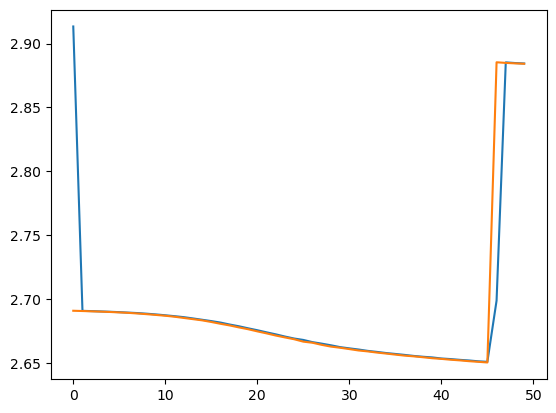

In [123]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

1/1 [==============================] - 0s 29ms/step


IndexError: index 1 is out of bounds for axis 0 with size 1

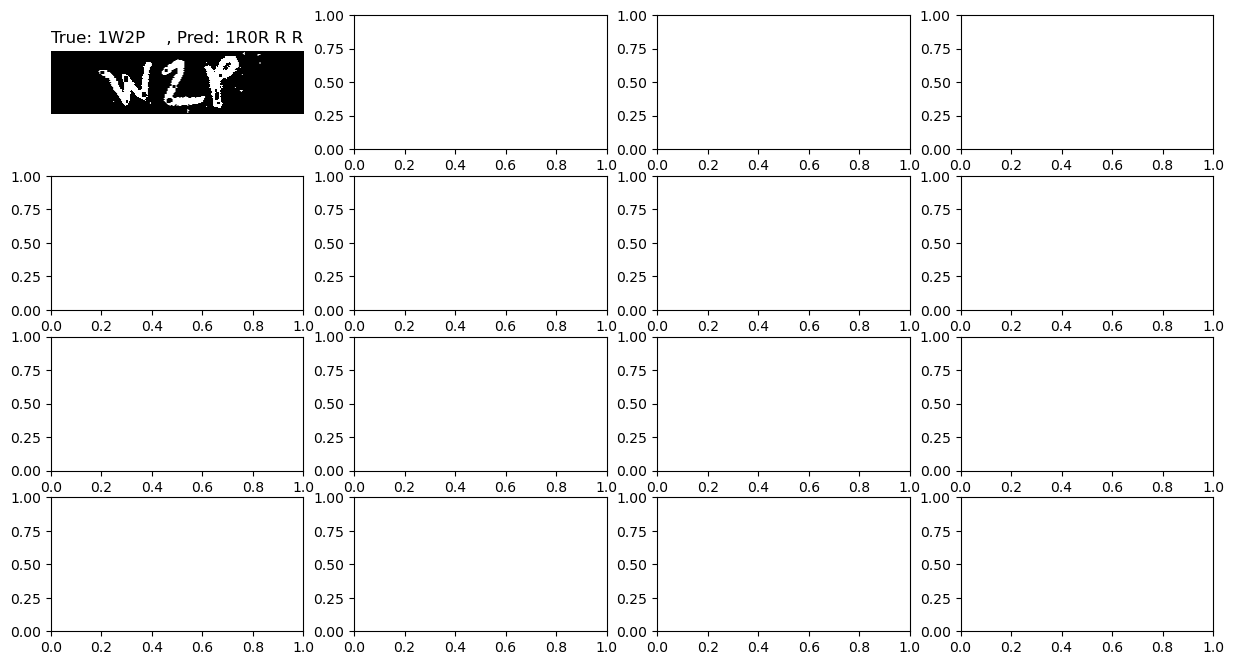

In [124]:
def decode_vectorized_label(results):

    results = np.argmax(results,axis=2)
    results[results==0] = 1
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)

    return output_text



#  Let's check results on some test samples.
batch = train_dl[1]
# batch_images = batch["image"]
# batch_labels = batch["label"]
batch_images = batch[0]
batch_labels = batch[1]
_, ax = plt.subplots(4, 4, figsize=(15, 8))

preds = prediction_model.predict(batch_images)
pred_texts = decode_vectorized_label(preds)
true_texts = decode_vectorized_label(batch_labels)

for i in range(16):
    img = batch_images[i]
    # img = tf.image.flip_left_right(img)
    # img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"True: {true_texts[i].split('[')[0]}, Pred: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")

plt.show()

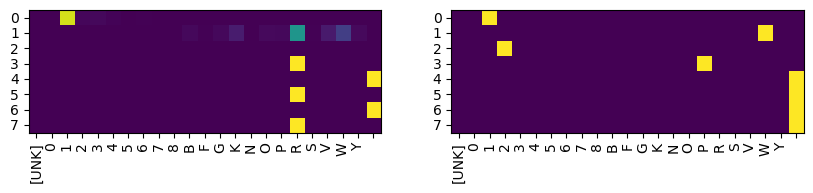

In [125]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

i=0

ax[0].imshow(preds[i])
ax[1].imshow(batch_labels[i])
for i in range(2):
    ax[i].set_xticks(range(len(num_to_char.get_vocabulary()))); ax[i].set_xticklabels(num_to_char.get_vocabulary(), rotation=90);
    ax[i].set_yticks(range(8));

1/1 [==============================] - 0s 128ms/step


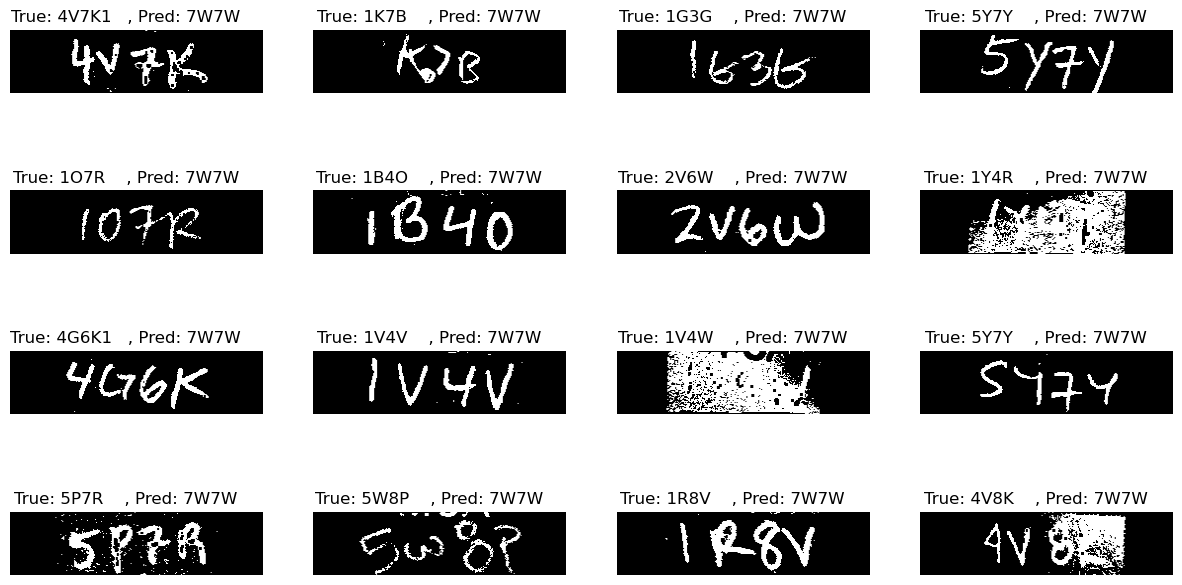

In [37]:
#  Let's check results on some test samples.
batch = val_dl[1]
batch_images = batch[0]
batch_labels = batch[1]
_, ax = plt.subplots(4, 4, figsize=(15, 8))

preds = prediction_model.predict(batch_images)
pred_texts = decode_vectorized_label(preds)
true_texts = decode_vectorized_label(batch_labels)

for i in range(16):
    img = batch_images[i]
    # img = tf.image.flip_left_right(img)
    # img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"True: {true_texts[i].split('[')[0]}, Pred: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
